# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Code Structure

In this notebook, I have tried to follow a pattern in which, within each code cell, I implement a function for a task, and towards the end of the cell, I have a 'test' function which invokes that function right away, so that we are testing the functionality as we are building it out. This reduces surprises, when we start using the functions later on to do more complex tasks.

## Common Constants

In [101]:
# Useful to have these defined up front for clear visibility

const_desired_accuracy_for_validation_data = 0.939 # A bit more than the project requiremenets of 93%

const_minimum_validation_accuracy_to_save_to_disk = 0.90 # Start saving model(s) to disk once we reach this threshold, early on in the training process this threshold can be low, and as we train further, we can increase this.

const_model_name_to_save = './jltrafficclassifier' # probably a better name would be germantrafficclassifier

const_new_images_folder = "NewImages/" # Folder where new images sourced from the internet are located

const_top_k_softmax = 5 # For new image categorization, this constant defines the top 'X' predicted classes

const_for_pixel_normalization = 128.0 # Constant for image pixel intensity normalization ( because pixel intensity range is 0, 255 )

const_get_top_x_misclassified_classes = 3 # Once a trained model is used to make predictions, this constant is used to determine how many misclassified classes to we want to investigate 



## Common Imports

In [2]:
# Including common imports for the notebook
# There might be a slight performance penalty in including these all up front rather than including them as needed, but it definitely improves the readability

import numpy as np
import os # Used for inspecting the folder structure, and loading or writing files to disk
import sys
import time # Used for calculating the run-time of code segments
import scipy
import json
import matplotlib.pyplot as plt
# this signifies that we will use matplotlib to show graphics inline within the jupyter notebook
%matplotlib inline
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import copy # Used to make copy of images for processing, rather than operating on the original images
import resource # Useful for getting memory usage
from random import randint
import operator


## Define Convenience Logging Functions

In [3]:
# Useful to selectively turn on / off logging at different levels

const_info_log_enabled = True
def infoLog(logMessage):
    if const_info_log_enabled == True:
        print("")
        print(logMessage)

const_debug_log_enabled = True
def debugLog(logMessage):
    if const_debug_log_enabled == True:
        print("")
        print(logMessage)
        
const_warning_log_enabled = True
def warningLog(logMessage):
    if const_warning_log_enabled == True:
        print("")
        print(logMessage)
        
const_error_log_enabled = True
def errorLog(logMessage):
    if const_error_log_enabled == True:
        print("")
        print(logMessage)
        

### Convenience Function to print memory usage

In [99]:
# Early on in the training process, I ran into issues where I was getting a memory error
# This was resolved by terminating the Docker process, terminating all notebooks, restarting Chrome, relaunching Docker, and relaunching the notebooks
# Jupyter notebooks tend to become 'heavy' when there size increases, so the restarts were a regular feature ( once everyday ) of the overall process

def print_memory_usage():
    infoLog("{} Kb".format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    
print_memory_usage()



1313760 Kb


### Convenience Mapper to convert a classId to Sign Name

In [100]:
## Provides an easy way to convert the class ID to a human interpretable format
## Allows us to avoid having to do a manual lookup of signnames.csv each time. 
## A better approach would be to read the CSV file, and to not have this hard coded here, but this is sufficient for us 

classIdSignNameDict = {0:"Speed limit (20km/h)",
1:"Speed limit (30km/h)",
2:"Speed limit (50km/h)",
3:"Speed limit (60km/h)",
4:"Speed limit (70km/h)",
5:"Speed limit (80km/h)",
6:"End of speed limit (80km/h)",
7:"Speed limit (100km/h)",
8:"Speed limit (120km/h)",
9:"No passing",
10:"No passing for vehicles over 3.5 metric tons",
11:"Right-of-way at the next intersection",
12:"Priority road",
13:"Yield",
14:"Stop",
15:"No vehicles",
16:"Vehicles over 3.5 metric tons prohibited",
17:"No entry",
18:"General caution",
19:"Dangerous curve to the left",
20:"Dangerous curve to the right",
21:"Double curve",
22:"Bumpy road",
23:"Slippery road",
24:"Road narrows on the right",
25:"Road work",
26:"Traffic signals",
27:"Pedestrians",
28:"Children crossing",
29:"Bicycles crossing",
30:"Beware of ice/snow",
31:"Wild animals crossing",
32:"End of all speed and passing limits",
33:"Turn right ahead",
34:"Turn left ahead",
35:"Ahead only",
36:"Go straight or right",
37:"Go straight or left",
38:"Keep right",
39:"Keep left",
40:"Roundabout mandatory",
41:"End of no passing",
42:"End of no passing by vehicles over 3.5 metric tons"}

def getSignNameForClassId(classId):
    return classIdSignNameDict[classId]

infoLog(getSignNameForClassId(0))



Speed limit (20km/h)


## Define Convenience Function to rotate an image by an arbitrary angle

In [6]:
# This can be used to rotate an image to manufacture fake data

from scipy.ndimage import rotate

def rotateImage(image):
    randomRotationAngle = np.random.randint(0, 360)
    rotated_image = rotate(image, randomRotationAngle, reshape=False)
    return rotated_image


## Define Convenience Function to visualize samples of an image data array

In [7]:
# Given an array of images, this function plots 10 random images from this array
# Also does a lookup on the class ID to provide a convenient title for the image, for quick validation

def visualizeSamplesFromData(image_data_array, labels_array):
    for counter in range(0, 10):
        image_index = np.random.randint(0, len(image_data_array))
        image = image_data_array[image_index]
        labelId = labels_array[image_index]
        labelIdName = getSignNameForClassId(labelId)
        squeezedImage = image.squeeze()
        plt.figure(figsize=(3,3))
        plt.title(labelIdName)
        plt.imshow(squeezedImage) 
        

## Define Convenience Function to store data as JSON file for later analysis

In [8]:
# At the end of the training and validation process after all epochs have executed, we write the overall performance, run time, accuracy trends to a JSON file on the Disk under the folder data_for_analysis 
# I chose JSON because this is human readable / consumable easily.
# The name of the file is the current epoch time - e.g. '1492470140.0814645', which you can view with a text editor

import json

const_data_analysis_folder = 'data_for_analysis'

def saveDataToDiskAsJson(data):
    if not os.path.exists(const_data_analysis_folder):
        os.makedirs(const_data_analysis_folder)
    currentTime = time.time()
    filename = const_data_analysis_folder + '/' + str(currentTime)
    try:
        with open(filename, 'w') as outfile:
            json.dump(data, outfile)
            debugLog("Performance Data Stored as JSON file to: " + filename)
    except IndexError:
        warningLog("Caught IndexError in saveDataToDiskAsJson.")
        
def getDataFromDisk(filename):
    filename = const_data_analysis_folder + '/' + filename
    with open(filename) as infile:
        data = json.load(infile)
        

## Define Convenience Function to store data as pickle file for later analysis

In [9]:
# Sample to write Data as Pickle File and read it back
# Pickle file(s) are used in the project to save and restore Normalized training data, under the folder 'pickle_data_for_analysis'
# As part of the validation process, we write and read back a file named apple.pickle to the folder

import pickle

data_to_test_pickle = {1,2,3,4,5}

const_pickle_data_analysis_folder = 'pickle_data_for_analysis'

def saveDataToDiskAsPickle(data, param_filename = None):
    if not os.path.exists(const_pickle_data_analysis_folder):
        os.makedirs(const_pickle_data_analysis_folder)

    fileName = param_filename
    
    if not fileName:
        filename = str(time.time())
    
    filename = const_pickle_data_analysis_folder + '/' + param_filename + '.pickle'
    
    debugLog("Data writing started : " + filename)

    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, pickle.HIGHEST_PROTOCOL) 
    
    debugLog("Data writing complete : " + filename)

        
def getDataFromPickleFile(filename):
    returnData = None
    filename = const_pickle_data_analysis_folder + '/' + filename + '.pickle'
    try:
        with open(filename, 'rb') as handle:
            returnData = pickle.load(handle)
            infoLog("Found data for " + filename)
        return returnData
    except FileNotFoundError:
        return None
        
saveDataToDiskAsPickle(data_to_test_pickle, 'apple')
debugLog(getDataFromPickleFile("apple"))



Data writing started : pickle_data_for_analysis/apple.pickle

Data writing complete : pickle_data_for_analysis/apple.pickle

Found data for pickle_data_for_analysis/apple.pickle

{1, 2, 3, 4, 5}


## Define Convenience Function to make sound

In [10]:
# This can be used to indicate the completion of training for example
# This works on a Mac, but not sure of other platforms

def makeSound():
    os.system("printf '\a'") # or '\7'    
    

## Define Convenience method to show progress indicator of a process

In [11]:
# Shows a nice progress bar for long running operations
# Used From - http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console

def progressIndicator(count, total, suffix=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()  
    

---
## Step 0: Load The Data

### Load training data from Disk ( normalized or non-normalized )

In [ ]:
# This section is used to load the normalized training data, if stored already on the Disk
# If training data has not been normalized, we load the 'default' data as provided in the original set, and normalize and save it later

import pickle
import numpy

# Load training data
training_file = 'traffic-signs-data/train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

X_train, y_train = train['features'], train['labels']

infoLog("Training Data Keys : " + str(train.keys()))

# Check if we already have normalized data saved to disk
X_train_normalized = getDataFromPickleFile('X_train_normalized')
y_train_normalized = getDataFromPickleFile('y_train_normalized')

is_training_data_normalized = False

if X_train_normalized is not None:
    infoLog("Normalized training data loaded from Disk.")
    is_training_data_normalized = True
    X_train = X_train_normalized
    y_train = y_train_normalized
else:
    infoLog("Training data has not been previously normalized.")
    is_training_data_normalized = False    
    

### Normalize the training data ( if not already normalized ) and store to Disk

In [96]:
# Take a random image and preprocess it by normalizing it
# This is useful to confirm the normalization process
# We only run this if the data has not been normalized previously

import numpy as np

# Given an image, creates a copy of the same, and then performs normalization on it and returns it
def normalize_image(image):
    image = image.astype(np.float32)
    return_image = copy.copy(image)
    for index,pixel in np.ndenumerate(return_image):
#         infoLog("Pixel Intensity Before Normalization : " + str(pixel))
        pixel = (pixel-const_for_pixel_normalization) / const_for_pixel_normalization
#         infoLog("Pixel Intensity After Normalization : " + str(pixel))
        return_image[index] = pixel
    return return_image

if is_training_data_normalized == False:
    index = random.randint(0, len(X_train))
    random_image = X_train[index]
    squeezedImage = random_image.squeeze()
    plt.figure(figsize=(3,3))
    plt.imshow(squeezedImage)

    normalized_image = normalize_image(random_image)
    squeezedNormalizedImage = normalized_image.squeeze()
    plt.figure(figsize=(3,3))
    plt.imshow(squeezedNormalizedImage)

    debugLog("Sign Name : " + getSignNameForClassId(y_train[index]))
    
# If the complete training data set has not been normalized previously we perform normalization on the complete training data set

if is_training_data_normalized == False:
    num_training_samples = len(X_train)
    X_train = X_train.astype(np.float32)
    debugLog("X_train data type : " + str(X_train.dtype))

    debugLog("START -- Preprocessing step - normalization - for all training images - Count : " + str(num_training_samples))
    start_preprocessing_normalization_time = time.time()

    for index in range(0, num_training_samples):
        image = X_train[index]
        normalizedImage = normalize_image(image)
        X_train[index] = normalizedImage
        progressIndicator(index,num_training_samples)

    end_preprocessing_normalization_time = time.time() 
    timediff_preprocessing_normalization_time = end_preprocessing_normalization_time - start_preprocessing_normalization_time
    debugLog("END -- Preprocessing step - normalization - for all training images in : " + str(timediff_preprocessing_normalization_time) + " seconds")
    
    # JL - Save preprocessed ( normalized ) data to Disk
    saveDataToDiskAsPickle(X_train, 'X_train_normalized')
    saveDataToDiskAsPickle(y_train, 'y_train_normalized')
    is_training_data_normalized = True
    
else:
    debugLog("Training data is already normalized, skipping normalization")
    


Training data is already normalized, skipping normalization


### Visualize the training data after normalization

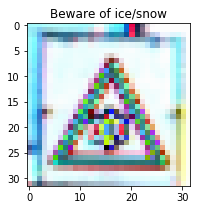

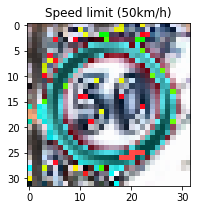

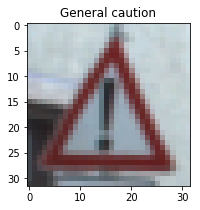

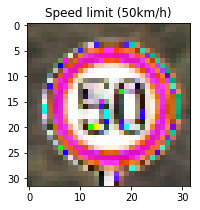

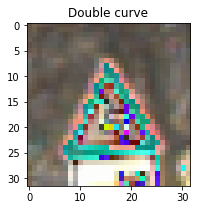

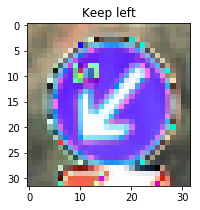

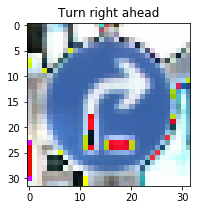

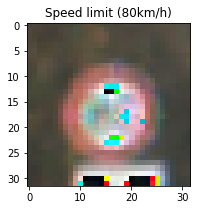

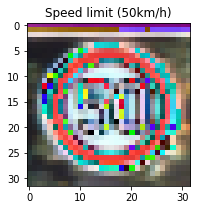

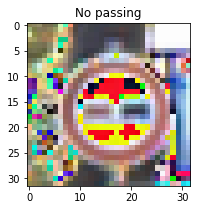

In [97]:
visualizeSamplesFromData(X_train,y_train)

### Load the validation and testing data

In [12]:
# Load pickled data as downloaded from https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
# We load the validation and testing data initially, while the training data is loaded later

import pickle
import numpy

# TODO: Fill this in based on where you saved the training and testing data

validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# JL - explore the data keys
infoLog("Validation Data Keys : " + str(valid.keys()))
infoLog("Test Data Keys : " + str(test.keys()))

# JL - explore data shape
X_valid_shape = X_valid.shape
y_valid_shape = y_valid.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape

infoLog("Shape of X_valid : " + str(X_valid_shape))
infoLog("Shape of y_valid : " + str(y_valid_shape))
infoLog("Shape of X_test : " + str(X_test_shape))
infoLog("Shape of y_test : " + str(y_test_shape))



Validation Data Keys : dict_keys(['coords', 'labels', 'sizes', 'features'])

Test Data Keys : dict_keys(['coords', 'features', 'sizes', 'labels'])

Shape of X_valid : (4410, 32, 32, 3)

Shape of y_valid : (4410,)

Shape of X_test : (12630, 32, 32, 3)

Shape of y_test : (12630,)


### Include an exploratory visualization of the validation dataset 

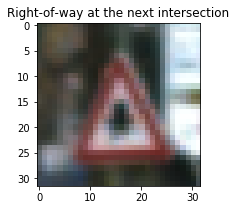

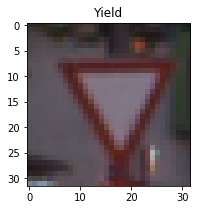

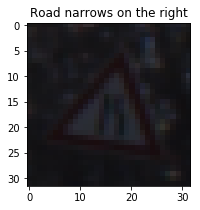

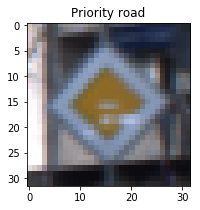

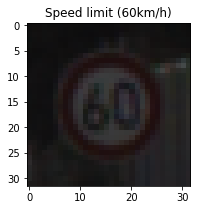

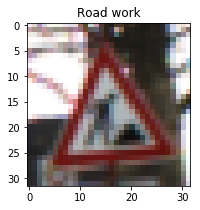

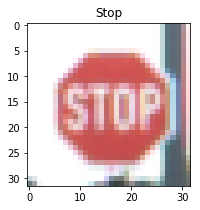

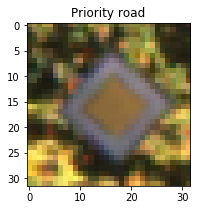

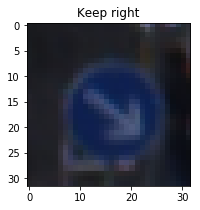

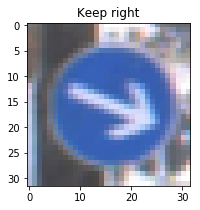

In [13]:
visualizeSamplesFromData(X_valid,y_valid)

### Include an exploratory visualization of the testing dataset 

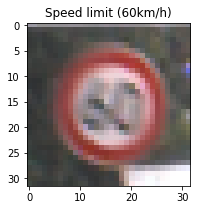

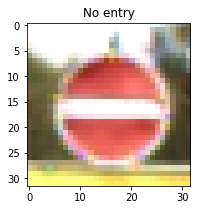

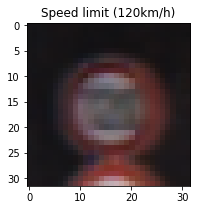

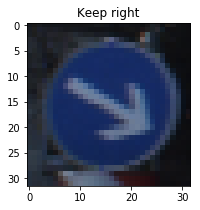

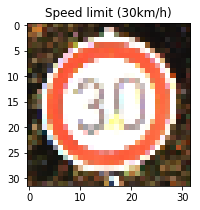

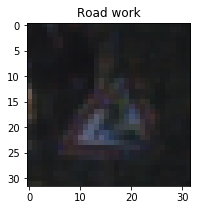

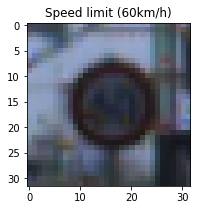

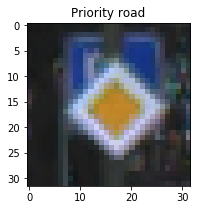

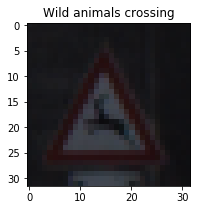

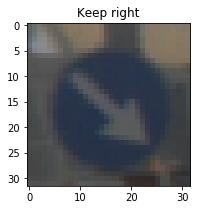

In [14]:
visualizeSamplesFromData(X_test,y_test)

### Explore shape of training data

In [16]:
# Explore shape of the training data

X_train_shape = X_train.shape
y_train_shape = y_train.shape

infoLog("Shape of X_train : " + str(X_train_shape))
infoLog("Shape of y_train : " + str(y_train_shape)) 


Shape of X_train : (34799, 32, 32, 3)

Shape of y_train : (34799,)


### Explore unique data labels by viewing labels from training, validation and test data

In [17]:
# Explore unique data labels

combined_labels_array = numpy.concatenate((y_train,y_valid,y_test))
num_of_unique_labels_in_all_data = len(numpy.unique(combined_labels_array))
infoLog("Total Number of Unique Labels: " + str(num_of_unique_labels_in_all_data))


Total Number of Unique Labels: 43


### Explore shape of one training image

In [18]:
# Explore shape of one training image, so that we know the shape of the input to our neural network

X_train_zero_shape = X_train[0].shape
infoLog("Shape of X_train[0] : " + str(X_train_zero_shape))


Shape of X_train[0] : (32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [20]:
# Additional data points regarding training, validation and test data

# Number of training examples
n_train = X_train_shape[0]

# Number of validation examples
n_validation = X_valid_shape[0]

# Number of testing examples.
n_test = X_test_shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_test_shape[1],X_test_shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = num_of_unique_labels_in_all_data

infoLog("Number of training examples = " + str(n_train))
infoLog("Number of validation examples = " + str(n_validation))
infoLog("Number of testing examples = " + str(n_test))
infoLog("Image data shape = " + str(image_shape))
infoLog("Number of classes = " + str(n_classes))


Number of training examples = 34799

Number of validation examples = 4410

Number of testing examples = 12630

Image data shape = (32, 32)

Number of classes = 43


### Explore distribution of number of training labels for various classes

Our goal here is to determine which classes are more heavily represented in the training data, and to then increased the representation for under represented classes so that the model gets proper training on all types of classifier(s)


function: generate_class_distribution

Labels Dictionary : {0: 180, 1: 1980, 2: 2010, 3: 1260, 4: 1770, 5: 1650, 6: 360, 7: 1290, 8: 1260, 9: 1320, 10: 1800, 11: 1170, 12: 1890, 13: 1920, 14: 690, 15: 540, 16: 360, 17: 990, 18: 1080, 19: 180, 20: 300, 21: 270, 22: 330, 23: 450, 24: 240, 25: 1350, 26: 540, 27: 210, 28: 480, 29: 240, 30: 390, 31: 690, 32: 210, 33: 599, 34: 360, 35: 1080, 36: 330, 37: 180, 38: 1860, 39: 270, 40: 300, 41: 210, 42: 210}

Mean num classes per label: 809

Standard Deviation of num classes per label: 619.420183705

Max num classes per label : 2010


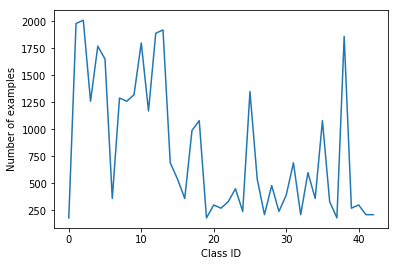

In [98]:
# Generate and visualize statistics regarding distribution of Class Labels and Instances for training data
# This is useful to determine which classes are highly represented, and which classes are less represented
# By intuition, the neural network will learn those classes better, for whom we have more training data, and will learn those classes poorly, for whom we have less training data

import numpy as np
import matplotlib.pyplot as plt

def generate_class_distribution(classArray):
    classIds, countsForClassIds = np.unique(classArray, return_counts=True)
    labels_count_dictionary = dict(zip(classIds, countsForClassIds))
    mean_number_of_samples_per_class_list_training_data = int(np.mean(countsForClassIds))
    standard_deviation_number_of_samples_per_class_list_training_data = np.std(countsForClassIds)
    max_number_of_samples_per_class_list_training_data = int(np.max(countsForClassIds))
    
    debugLog("function: generate_class_distribution")
    debugLog("Labels Dictionary : " + str(labels_count_dictionary))
    debugLog("Mean num classes per label: " + str(mean_number_of_samples_per_class_list_training_data))
    debugLog("Standard Deviation of num classes per label: " + str(standard_deviation_number_of_samples_per_class_list_training_data))
    debugLog("Max num classes per label : " + str(max_number_of_samples_per_class_list_training_data))
    
    return labels_count_dictionary, mean_number_of_samples_per_class_list_training_data,standard_deviation_number_of_samples_per_class_list_training_data,max_number_of_samples_per_class_list_training_data

def visualize_class_distribution(labels_count_dictionary):
                    
    classIdlist_training_data = list(labels_count_dictionary.keys())
    number_of_samples_per_class_list_training_data = list(labels_count_dictionary.values())
    plt.plot(classIdlist_training_data,number_of_samples_per_class_list_training_data)
    plt.ylabel('Number of examples')
    plt.xlabel('Class ID')
    plt.show()

labels_count_dictionary, mean_number_of_samples_per_class_list_training_data, standard_deviation_number_of_samples_per_class_list_training_data, max_number_of_samples_per_class_list_training_data = generate_class_distribution(y_train)

visualize_class_distribution(labels_count_dictionary)

In [22]:
# Separate into under-represented and over-represented classes by calculating mean
# We also calculate 'how much' is a class under-represented or 'over-represented', so that this information can be used in generating fake data

training_data_under_represented_classes_dict = dict()
training_data_over_represented_classes_dict = dict()

for class_id, number_of_samples in labels_count_dictionary.items():
    # Evaluate how big is the difference of the number of features for a class from the mean, relative to itself
    # boost_ratio = number of times number_of_samples has to be 'added' to itself to equal 'max_number_of_samples_per_class_list_training_data'
    # We do not want to reject any data, so we will not reject any features for now
    ratio = (mean_number_of_samples_per_class_list_training_data - number_of_samples) / number_of_samples
    if ratio >= 0:
        boost_ratio = int(ratio)
        training_data_under_represented_classes_dict[class_id] = boost_ratio
    else:
        training_data_over_represented_classes_dict[class_id] =  ratio
        
debugLog("Classes with under representation in training samples : " + str(training_data_under_represented_classes_dict))
debugLog("Classes with over representation in training samples : " + str(training_data_over_represented_classes_dict))

def is_class_underrepresented(classId):
    boost_ratio = training_data_under_represented_classes_dict.get(classId, None)
    if boost_ratio:
        return boost_ratio
    else:
        return False
    
def is_class_overrepresented(classId):
    ratio = training_data_over_represented_classes_dict.get(classId, None)
    if ratio:
        return ratio
    else:
        return False
    
infoLog("Is class with Class ID : 31 under represented : " + str(is_class_underrepresented(31)))
infoLog("Is class with Class ID : 1 over represented : " + str(is_class_overrepresented(1)))



Classes with under representation in training samples : {0: 3, 6: 1, 14: 0, 15: 0, 16: 1, 19: 3, 20: 1, 21: 1, 22: 1, 23: 0, 24: 2, 26: 0, 27: 2, 28: 0, 29: 2, 30: 1, 31: 0, 32: 2, 33: 0, 34: 1, 36: 1, 37: 3, 39: 1, 40: 1, 41: 2, 42: 2}

Classes with over representation in training samples : {1: -0.59141414141414139, 2: -0.59751243781094532, 3: -0.35793650793650794, 4: -0.54293785310734466, 5: -0.50969696969696965, 38: -0.56505376344086022, 7: -0.37286821705426354, 8: -0.35793650793650794, 9: -0.38712121212121214, 10: -0.55055555555555558, 11: -0.30854700854700856, 12: -0.571957671957672, 13: -0.5786458333333333, 17: -0.18282828282828284, 18: -0.25092592592592594, 35: -0.25092592592592594, 25: -0.40074074074074073}

Is class with Class ID : 31 under represented : False

Is class with Class ID : 1 over represented : -0.591414141414


In [108]:
# Iterate over training feature and label set and do a 'Boost' of under-represented features, that is generate fake data for them
# Data 'equalization' can be verified by regenerating the standard deviation of class distribution and checking that the standard deviation has reduced from the original data set

debugLog("Started - Preparing additional data set with fake data generated for under represented classes ")

training_data_boosted_labels_list = list()
training_data_boosted_features_list = list()

X_train_fake_normalized = list() # Stands for list of features which are fake / generated and normalized
y_train_fake_normalized = list()

# Check if we already have normalized fake data saved to disk
X_train_fake_normalized_from_disk = getDataFromPickleFile('X_train_fake_normalized')
y_train_fake_normalized_from_disk = getDataFromPickleFile('y_train_fake_normalized')
is_fake_normalized_data_saved_to_disk = False

if X_train_fake_normalized_from_disk is not None:
    is_fake_normalized_data_saved_to_disk = True
    X_train_fake_normalized = X_train_fake_normalized_from_disk
    y_train_fake_normalized = y_train_fake_normalized_from_disk
    
if is_fake_normalized_data_saved_to_disk == False:
    debugLog("Start generating fake data.")
    number_of_labels = len(y_train)
    for index, class_id in enumerate(y_train):
        boost_ratio_underrepresented = is_class_underrepresented(class_id)
        boost_ratio_overrepresented = is_class_overrepresented(class_id)

        if boost_ratio_underrepresented:
        # Add boosted image and feature
            for i in range(0,boost_ratio_underrepresented):
                X_train_fake_normalized.append(rotateImage(X_train[index]))
                y_train_fake_normalized.append(class_id)
    
        progressIndicator(index,number_of_labels)
    
    saveDataToDiskAsPickle(X_train_fake_normalized, 'X_train_fake_normalized')
    saveDataToDiskAsPickle(y_train_fake_normalized, 'y_train_fake_normalized')
    debugLog("Generated fake data stored to disk.")
    infoLog("Number of elements in :  X_train_fake_normalized = " + str(len(X_train_fake_normalized)))
    infoLog("Number of elements in :  y_train_fake_normalized = " + str(len(y_train_fake_normalized)))
    visualizeSamplesFromData(X_train_fake_normalized,y_train_fake_normalized)
else:
    debugLog("Fake data loaded from Disk, skipping regeneration.")
    

debugLog("Ended - Preparing additional data set with fake data generated for under represented classes ")



Started - Preparing additional data set with fake data generated for under represented classes 

Found data for pickle_data_for_analysis/X_train_fake_normalized.pickle

Found data for pickle_data_for_analysis/y_train_fake_normalized.pickle

Fake data loaded from Disk, skipping regeneration.

Ended - Preparing additional data set with fake data generated for under represented classes 


### Explore the numeric distribution from the fake generated data set


In [111]:

fake_data_labels_count_dictionary, fake_data_mean_number_of_samples, fake_data_standard_deviation_number_of_samples, fake_data_max_number_of_samples = generate_class_distribution(y_train_fake_normalized)



function: generate_class_distribution

Labels Dictionary : {0: 540, 32: 420, 34: 360, 36: 330, 37: 540, 6: 360, 39: 270, 40: 300, 41: 420, 42: 420, 16: 360, 19: 540, 20: 300, 21: 270, 22: 330, 24: 480, 27: 420, 29: 480, 30: 390}

Mean num classes per label: 396

Standard Deviation of num classes per label: 86.280480583

Max num classes per label : 540


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [25]:
### Shuffle the training data 

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### HyperParameters / Tunable Parameter(s)

In [29]:
# Useful to identify these parameters up-front so that we know what 'knobs' to have to control the network 

param_epochs = 30
param_batchsize = 128
param_mean = 0
param_standard_deviation = 0.1
param_learning_rate = 0.001
param_activation_function = 'ReLU'
param_pooling_function = 'Max'
param_architecture_updates = '1. Incresed Filter Depths 2. Increased Size of fully connected layers 3. Added a convolution layer.' 
param_preprocessing_updates = '1. Implemented Normalization '
param_data_augmentation_updates = ' '
# param_data_augmentation_updates = '1. Implemented boosting of under represented classes and rejection of under represented classes.'


### Model Architecture

In [30]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [31]:
import tensorflow as tf

S = param_epochs
BATCH_SIZE = param_batchsize
mu = param_mean
sigma = param_standard_deviation
const_initial_learning_rate = param_learning_rate

In [32]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [33]:
# Convenience methods to create convolution layers, given input features, weights, biases, convolution filter stride, convolution filter size, convolution filter depth, pooling filter size, and pooling filter stride
# Initial architecture chosen was the LeNet architecture.
# To achieve the current accuracy ( 93.94 %) I made the following updates to the architecture :
# Increased the filter depth for convolution layers.
# Increased the dimensions of the fully connected layers.
# Added one more convolution layer with pooling.
# Introduced Dropout regularization ( with keep probability of 0.7 for training process, and 1 for validation and testing process.)
# Other than the above I experimented with adding one more convolution layer, but I did not see significant gain(s) from this and discarded this layer.
# During my experimentation phase, I achieved a best validation accuracy of 96.5%, though at the time, I did not know how to restore a saved model, and thus lost it.
# With this architecure in place, I was consistently hitting a validation accuracy of 90%+ within the first 7 epochs.

from tensorflow.contrib.layers import flatten
    
# Jai - Helper methods
def maxpool2d(x, poolingsize=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, poolingsize, poolingsize, 1],
        strides=[1, poolingsize, poolingsize, 1],
        padding='VALID')
      
def conv2d_with_pooling(x, W, b, convstride=1, poolingsize=2):
        x = tf.nn.conv2d(x, W, strides=[1, convstride, convstride, 1], padding='VALID')
        x = tf.nn.bias_add(x, b)
        x = tf.nn.relu(x)
        x = maxpool2d(x)
        return x
    
def conv2d(x, W, b, convstride=1):
        x = tf.nn.conv2d(x, W, strides=[1, convstride, convstride, 1], padding='VALID')
        x = tf.nn.bias_add(x, b)
        x = tf.nn.relu(x)
        return x
    
# Jai - Define Weights based on calculations below
weights = {
    'wconv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean=mu, stddev = sigma), name='wconv1'),
    'wconv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev = sigma), name='wconv2'),
    'wconv3': tf.Variable(tf.truncated_normal(shape=(2, 2, 32, 256), mean=mu, stddev = sigma), name='wconv3'),
    'wfc1': tf.Variable(tf.truncated_normal(shape=(1024,240), mean=mu, stddev = sigma), name='wfc1'),
    'wfc2': tf.Variable(tf.truncated_normal(shape=(240,168), mean=mu, stddev = sigma), name='wfc2'),
    'woutput': tf.Variable(tf.truncated_normal(shape=(168,43), mean=mu, stddev = sigma), name='woutput')}
    
# Jai - Define Biases based on calculations below
biases = {
    'bconv1': tf.Variable(tf.zeros([16]), name='bconv1'),
    'bconv2': tf.Variable(tf.zeros([32]), name='bconv2'),
    'bconv3': tf.Variable(tf.zeros([256]), name='bconv3'),
    'bfc1': tf.Variable(tf.zeros([240]), name='bfc1'),
    'bfc2': tf.Variable(tf.zeros([168]), name='bfc2'),
    'boutput': tf.Variable(tf.zeros([43]), name='boutput')
    }

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    
    # Layer 1: Convolutional. Input = 32x32x3. Output w/Pooling = 14x14x16.
    # Input Volume = 3072 Output Volume = 3136
    convlayer1 = conv2d_with_pooling(x,weights['wconv1'],biases['bconv1'],1,2)
    debugLog(convlayer1.get_shape())
    
    # Layer 2: Convolutional. Output w/Pooling = 5x5x32.
    # Input Volume = 3136 Output Volume = 800
    convlayer2 = conv2d_with_pooling(convlayer1,weights['wconv2'],biases['bconv2'],1,2)
    debugLog(convlayer2.get_shape())
    
    # Layer 3: Convolutional. Output w/Pooling = 2x2x256.
    # Input Volume = 800 Output Volume = 1024
    convlayer3 = conv2d_with_pooling(convlayer2,weights['wconv3'],biases['bconv3'],1,2)
    debugLog(convlayer3.get_shape())
    
    # Layer 4 - Flatten. Input = 2x2x256. Output = 1024.
    # Input Volume = 1024 Output Volume = 1024
    flattened_convlayer4 = tf.contrib.layers.flatten(convlayer3)   
    debugLog(flattened_convlayer4.get_shape())
    
    # Layer 5 - Fully Connected #1. Input = 1024. Output = 240.
    # Input Volume = 1024 Output Volume = 240
    fc1 = tf.add(tf.matmul(flattened_convlayer4,weights['wfc1']),biases['bfc1'])
    
    # Activation.
    fc1_activated = tf.nn.relu(fc1)

    # Layer 6 - Fully Connected #2. Input = 240. Output = 168.
    # Input Volume = 1024 Output Volume = 168
    fc2 = tf.add(tf.matmul(fc1_activated,weights['wfc2']),biases['bfc2'])
    
    # Activation.
    fc2_activated = tf.nn.relu(fc2)
    
    # Layer 7 - Drop Out
    # Input Volume = 168 Output Volume = 168
    fc2_after_dropout = tf.nn.dropout(fc2_activated, keep_prob)

    # Layer 8 - Fully Connected #3. Input = 168. Output = 43.
    # Input Volume = 168 Output Volume = 43
    logits = tf.add(tf.matmul(fc2_after_dropout,weights['woutput']),biases['boutput'])
    
    return logits

In [34]:
rate = const_initial_learning_rate

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


(?, 14, 14, 16)

(?, 5, 5, 32)

(?, 2, 2, 256)

(?, 1024)


## Model Evaluation

## Evaluating Accuracy

In [35]:
# Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
        progressIndicator(offset, num_examples)
    return total_accuracy / num_examples

## Evaluating Inaccuracy - Classes for which prediction is failing

In [42]:
# Model evaluation

incorrect_prediction = tf.not_equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))


## Given the features, and labels, generates predictions from a pre-trained model ( saved on a checkpoint )
## to obtain a dictionary with key as the class ID, and value as the total number of instances of mislabelling
def evaluate_inaccuracy(X_data, y_data):
    BATCH_SIZE_FOR_INACCURACY = 1
    inaccurate_prediction_dict = dict()
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE_FOR_INACCURACY):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE_FOR_INACCURACY], y_data[offset:offset+BATCH_SIZE_FOR_INACCURACY]
        incorrect_prediction_value = sess.run(incorrect_prediction, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        if incorrect_prediction_value == True:
            current_number_of_incorrect_predictions_for_class = inaccurate_prediction_dict.get(y_data[offset],0)
            current_number_of_incorrect_predictions_for_class = current_number_of_incorrect_predictions_for_class + 1
            inaccurate_prediction_dict[y_data[offset]] = current_number_of_incorrect_predictions_for_class
        progressIndicator(offset, num_examples)
    return inaccurate_prediction_dict

## Converts the dictionary returned above into a sorted list and returns the top two classes for which the model is performing badly
def get_classes_with_worst_performance(inaccurate_prediction_dict, num_of_classes_to_return):
    sorted_prediction_list = sorted(inaccurate_prediction_dict.items(), key=operator.itemgetter(1), reverse=True) # itemgetter(1) implies sort by value
    top_classes_with_worst_performance = sorted_prediction_list[:num_of_classes_to_return]
    return top_classes_with_worst_performance

## Train and Validate

In [ ]:
with tf.Session() as sess:

    # If running training for the first time, uncomment sess.run, and comment out saver.restore, and if you want to
    # resume training then leavel sess.run commented out and run saver.restore
    sess.run(tf.global_variables_initializer())
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
       
    num_examples = len(X_train)
    
    debugLog("START -- Training and Validation ...")
    
    start_overall_time = time.time()
    validation_accuracy_list = list()
    training_accuracy_list = list()
    validation_accuracy = None
    highest_validation_accuracy = 0
    testing_accuracy = None
    
    epoch_counter = 0
    
    while epoch_counter < S and highest_validation_accuracy < const_desired_accuracy_for_validation_data:
        X_train, y_train = shuffle(X_train, y_train)
        
        # Train over the training data in batches
        start_training_time = time.time()
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.7})
            progressIndicator(end,num_examples)
        end_training_time = time.time()
        training_execution_time = end_training_time - start_training_time
        debugLog("Epoch : " + str(epoch_counter) + " Training time : " + str(training_execution_time) )
        
        # Evaluate prediction accuracy against validation data
        start_valdidation_time = time.time()
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_list.append(validation_accuracy)
        end_valdidation_time = time.time()
        validation_execution_time = end_valdidation_time - start_valdidation_time
        debugLog("")
        debugLog("Epoch : " + str(epoch_counter) + " Validation time : " + str(validation_execution_time) )
        debugLog(" Epoch {} - ".format(epoch_counter+1))
        debugLog("Prediction Accuracy against validation data = {:.3f}".format(validation_accuracy))
        
        if highest_validation_accuracy == 0:
            highest_validation_accuracy = validation_accuracy
            infoLog("Highest Validation accuracy was 0.")
        
        # JL - Saving at each epoch, so that we can pick this up at any time, and so that the model is available for us to experiment during the training process as wel
        if validation_accuracy >= highest_validation_accuracy:
            infoLog("Validation accuracy was > highest_validation_accuracy")
            highest_validation_accuracy = validation_accuracy
            if validation_accuracy >= const_minimum_validation_accuracy_to_save_to_disk:
                debugLog("Validation accuracy was > const_minimum_validation_accuracy_to_save_to_disk")
                int_validation_accuracy = int(validation_accuracy*10000) # 0.9315 => 9315
                model_name = const_model_name_to_save + str(int_validation_accuracy)
                saver.save(sess, model_name)
                debugLog("Saved model to Disk : " + model_name)
            else:
                infoLog("Validation accuracy was < const_minimum_validation_accuracy_to_save_to_disk")
                infoLog("Validation accuracy : " + str(validation_accuracy))
        else:
            infoLog("Validation accuracy was < highest_validation_accuracy")
            
        if highest_validation_accuracy >= const_desired_accuracy_for_validation_data:
            debugLog("Achieved desired validation accuracy of : " + str(const_desired_accuracy_for_validation_data) + " in epoch # : " + str(epoch_counter))
            
        # Evaluate prediction accuracy against training data
        debugLog("Evaluating prediction accuracy against training data...")
        start_training_accuracy_calculation_time = time.time()
        training_accuracy = evaluate(X_train, y_train)
        training_accuracy_list.append(training_accuracy)
        end_training_accuracy_calculation_time = time.time()
        training_accuracy_calculation_execution_time = end_training_accuracy_calculation_time - start_training_accuracy_calculation_time
        debugLog("Epoch : " + str(epoch_counter) + " Training Accuracy Calculation time ( seconds ): " + str(training_accuracy_calculation_execution_time) )
        debugLog("Epoch {} - ".format(epoch_counter+1))
        debugLog("Prediction Accuracy against training data = {:.3f}".format(training_accuracy))
        
        epoch_counter = epoch_counter + 1
    
    end_overall_time = time.time()
    overall_execution_time = end_overall_time - start_overall_time

    debugLog("END -- Training and Validation...")
    
    if highest_validation_accuracy >= const_desired_accuracy_for_validation_data:
        debugLog("Proceeding to evaluate predictions for testing data.")
        # Evaluate prediction accuracy against testing data if we have achieved desired validationa accuracy
        start_testing_accuracy_calculation_time = time.time()
        testing_accuracy = evaluate(X_test, y_test)
        end_testing_accuracy_calculation_time = time.time()
        testing_accuracy_calculation_execution_time = end_testing_accuracy_calculation_time - start_testing_accuracy_calculation_time
        debugLog("Testing Accuracy Calculation : " + str(testing_accuracy_calculation_execution_time) )
        debugLog("Prediction Accuracy against testing data = {:.3f}".format(testing_accuracy))
        
    # Prepare Data to Save to Disk
    performanceSummaryDict = {"param_epochs" : param_epochs,
    "param_batchsize" : param_batchsize,
    "param_mean" : param_mean,
    "param_standard_deviation" : param_standard_deviation,
    "param_learning_rate" : param_learning_rate,
    "param_activation_function" : param_activation_function,
    "param_architecture_updates" : param_architecture_updates,
    "param_preprocessing_updates" : param_preprocessing_updates,
    "param_data_augmentation_updates" : param_data_augmentation_updates, 
    "param_pooling_function" : param_pooling_function,
    "overall_execution_time" : overall_execution_time,
    "average_training_and_validation_time" : overall_execution_time/param_epochs,
    "validation_accuracy_trend" : ','.join(map(str,validation_accuracy_list)),
    "training_accuracy_trend" : ','.join(map(str,training_accuracy_list)),
    "validation_accuracy_on_last_epoch" : validation_accuracy,
    "max_validation_accuracy" : highest_validation_accuracy,
    "testing_dataset_accuracy" : testing_accuracy}

    # Prepare Performance Data to Disk
    saveDataToDiskAsJson(performanceSummaryDict)
    
    # Notify of completion
    makeSound()


### Accuracy against Training data set

### 99.7%

In [88]:
### Testing the final trained model against training data

training_accuracy = None

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    training_accuracy = evaluate(X_train, y_train)
    debugLog("Training Accuracy = {:.3f}".format(training_accuracy))

[============================================================] 99.7% ...
Training Accuracy = 0.998


### Inaccuracy against Training data set

Exploring the classes from the training data set which are being mis labelled by the model

In [39]:
###  Inaccuracy against Training data set

y_train_inaccurate_classified_count_by_class_id_dict = dict()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_train_inaccurate_classified_count_by_class_id_dict = evaluate_inaccuracy(X_train, y_train)
    
debugLog("Dictionary of class IDs and mis-labelling count for training data : " + str(y_train_inaccurate_classified_count_by_class_id_dict))

In [75]:
# Average out the mislabellings by dividing count of mislabelled, with total number of samples for that class
train_labels_count_dict, train_mean,train_std_dev, train_max_samples_per_class = generate_class_distribution(y_train)

train_mislabelled_ratio_by_class_dict = dict()

for class_id, total_samples in train_labels_count_dict.items():
    mislabelled_count = y_train_inaccurate_classified_count_by_class_id_dict.get(class_id,0)
    mislabelled_ratio = mislabelled_count / total_samples
    train_mislabelled_ratio_by_class_dict[class_id] = mislabelled_ratio
    debugLog("Training Class ID : " + str(class_id) + " ||| Mislabelled ratio : " + str(mislabelled_ratio))



function: generate_class_distribution

Labels Dictionary : {0: 180, 1: 1980, 2: 2010, 3: 1260, 4: 1770, 5: 1650, 6: 360, 7: 1290, 8: 1260, 9: 1320, 10: 1800, 11: 1170, 12: 1890, 13: 1920, 14: 690, 15: 540, 16: 360, 17: 990, 18: 1080, 19: 180, 20: 300, 21: 270, 22: 330, 23: 450, 24: 240, 25: 1350, 26: 540, 27: 210, 28: 480, 29: 240, 30: 390, 31: 690, 32: 210, 33: 599, 34: 360, 35: 1080, 36: 330, 37: 180, 38: 1860, 39: 270, 40: 300, 41: 210, 42: 210}

Mean num classes per label: 809

Standard Deviation of num classes per label: 619.420183705

Max num classes per label : 2010

Class ID : 0 ||| Mislabelled ratio : 0.0

Class ID : 1 ||| Mislabelled ratio : 0.000505050505051

Class ID : 2 ||| Mislabelled ratio : 0.0

Class ID : 3 ||| Mislabelled ratio : 0.0

Class ID : 4 ||| Mislabelled ratio : 0.0

Class ID : 5 ||| Mislabelled ratio : 0.00606060606061

Class ID : 6 ||| Mislabelled ratio : 0.0416666666667

Class ID : 7 ||| Mislabelled ratio : 0.0139534883721

Class ID : 8 ||| Mislabelled ra

In [84]:
# Pick Top mislabelled classes in training set

top_mislabelled_training_data_list = get_classes_with_worst_performance(train_mislabelled_ratio_by_class_dict,const_get_top_x_misclassified_classes)
debugLog("List of top mislabelled training data classes : " + str(top_mislabelled_training_data_list))

for (class_id,mislabelled_count) in top_mislabelled_training_data_list:
    debugLog(" Training Class: " + getSignNameForClassId(class_id) + " ||| Mislabelled count : " + str(mislabelled_count))


List of top mislabelled training data classes : [(6, 0.041666666666666664), (7, 0.013953488372093023), (30, 0.010256410256410256)]

 Training Class: End of speed limit (80km/h) ||| Mislabelled count : 0.0416666666667

 Training Class: Speed limit (100km/h) ||| Mislabelled count : 0.0139534883721

 Training Class: Beware of ice/snow ||| Mislabelled count : 0.0102564102564


### Accuracy against Validation data set

### 93.94%

Because the accuracy against the validation set is lower than that of the training set, this implies some level of underfitting. 

In [89]:

validation_accuracy = None

### Testing the final trained model against validation data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    validation_accuracy = evaluate(X_valid, y_valid)
    debugLog("Validation Accuracy = {:.3f}".format(validation_accuracy))

[===========================================================-] 98.7% ...
Validation Accuracy = 0.939


### Inaccuracy against Validation data set

Evaluate the classes in validation set for which the predictions are incorrect

In [48]:
###  Inaccuracy against Validation data set

y_valid_inaccurate_classified_count_by_class_id_dict = dict()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_valid_inaccurate_classified_count_by_class_id_dict = evaluate_inaccuracy(X_valid, y_valid)
    
debugLog("Dictionary of class IDs and mis-labelling count for validation data : " + str(y_valid_inaccurate_classified_count_by_class_id_dict))

[============================================================] 100.0% ...
Dictionary of class IDs and mis-labelling count for validation data : {0: 7, 1: 18, 2: 1, 3: 2, 5: 19, 6: 2, 7: 7, 8: 8, 9: 13, 10: 1, 11: 4, 13: 1, 15: 5, 16: 28, 17: 4, 18: 2, 20: 31, 21: 8, 23: 5, 24: 22, 25: 18, 26: 3, 27: 7, 29: 3, 30: 4, 31: 7, 32: 1, 33: 11, 36: 1, 38: 2, 40: 18, 41: 1, 42: 3}


In [81]:
# Average out the mislabellings by dividing count of mislabelled, with total number of samples for that class
valid_labels_count_dict, valid_mean,valid_std_dev, valid_max_samples_per_class = generate_class_distribution(y_valid)

valid_mislabelled_ratio_by_class_dict = dict()

for class_id, total_samples in valid_labels_count_dict.items():
    mislabelled_count = y_valid_inaccurate_classified_count_by_class_id_dict.get(class_id,0)
    mislabelled_ratio = mislabelled_count / total_samples
    valid_mislabelled_ratio_by_class_dict[class_id] = mislabelled_ratio
    debugLog("Validation Class ID : " + str(class_id) + " ||| Mislabelled ratio : " + str(mislabelled_ratio))


function: generate_class_distribution

Labels Dictionary : {0: 30, 1: 240, 2: 240, 3: 150, 4: 210, 5: 210, 6: 60, 7: 150, 8: 150, 9: 150, 10: 210, 11: 150, 12: 210, 13: 240, 14: 90, 15: 90, 16: 60, 17: 120, 18: 120, 19: 30, 20: 60, 21: 60, 22: 60, 23: 60, 24: 30, 25: 150, 26: 60, 27: 30, 28: 60, 29: 30, 30: 60, 31: 90, 32: 30, 33: 90, 34: 60, 35: 120, 36: 60, 37: 30, 38: 210, 39: 30, 40: 60, 41: 30, 42: 30}

Mean num classes per label: 102

Standard Deviation of num classes per label: 68.8474222468

Max num classes per label : 240

Class ID : 0 ||| Mislabelled ratio : 0.233333333333

Class ID : 1 ||| Mislabelled ratio : 0.075

Class ID : 2 ||| Mislabelled ratio : 0.00416666666667

Class ID : 3 ||| Mislabelled ratio : 0.0133333333333

Class ID : 4 ||| Mislabelled ratio : 0.0

Class ID : 5 ||| Mislabelled ratio : 0.0904761904762

Class ID : 6 ||| Mislabelled ratio : 0.0333333333333

Class ID : 7 ||| Mislabelled ratio : 0.0466666666667

Class ID : 8 ||| Mislabelled ratio : 0.053333333333

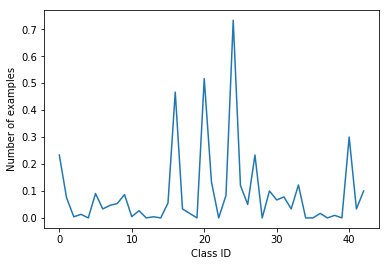

In [82]:
# Visualize distribution of mislabelled classes in the validation set

visualize_class_distribution(valid_mislabelled_ratio_by_class_dict)

In [83]:
# Pick Top mislabelled classes in validation set

top_mislabelled_validation_data_list = get_classes_with_worst_performance(valid_mislabelled_ratio_by_class_dict,const_get_top_x_misclassified_classes)
debugLog("List of top mislabelled validation data classes : " + str(top_mislabelled_validation_data_list))

for (class_id,mislabelled_count) in top_mislabelled_validation_data_list:
    debugLog("Class: " + getSignNameForClassId(class_id) + " ||| Mislabelled ratio : " + str(mislabelled_count))
    


List of top mislabelled validation data classes : [(24, 0.73333333333333328), (20, 0.51666666666666672), (16, 0.46666666666666667)]

Class: Road narrows on the right ||| Mislabelled count : 0.733333333333

Class: Dangerous curve to the right ||| Mislabelled count : 0.516666666667

Class: Vehicles over 3.5 metric tons prohibited ||| Mislabelled count : 0.466666666667


### Detect overfitting versus underfitting

In [94]:

if validation_accuracy > training_accuracy:
    debugLog("Validation_accuracy : " + str(validation_accuracy) + " > Training_accuracy,"  + str(training_accuracy) + " therefore we have over fitting.")
else:
    debugLog("Validation_accuracy : " + str(validation_accuracy) + " < Training_accuracy," + str(training_accuracy) + " therefore we have under fitting.")
    


Validation_accuracy : 0.939455782097 < Training_accuracy,0.998103393793 therefore we have under fitting.


### Accuracy against Testing data set

### 91.7%

In [90]:
test_accuracy = None

### Testing the trained model against test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    debugLog("Test Accuracy = {:.3f}".format(test_accuracy))

[============================================================] 99.3% ...
Test Accuracy = 0.917


### Inaccuracy against Testing data set

Evaluate the classes in testing set for which the predictions are incorrect

In [51]:
### Inaccuracy against Testing data set

y_test_inaccurate_classified_count_by_class_id_dict = dict()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_test_inaccurate_classified_count_by_class_id_dict = evaluate_inaccuracy(X_test, y_test)
    
debugLog("Dictionary of class IDs and mis-labelling count for testing data : " + str(y_test_inaccurate_classified_count_by_class_id_dict))

[============================================================] 100.0% ...
Dictionary of class IDs and mis-labelling count for testing data : {0: 3, 1: 23, 2: 35, 3: 41, 4: 30, 5: 121, 6: 35, 7: 85, 8: 42, 9: 21, 10: 17, 11: 17, 12: 27, 13: 11, 15: 49, 17: 36, 18: 43, 20: 37, 21: 29, 22: 20, 23: 2, 24: 49, 25: 30, 26: 33, 27: 36, 28: 8, 29: 3, 30: 33, 31: 44, 32: 1, 35: 15, 36: 1, 38: 28, 39: 10, 40: 12, 41: 7, 42: 20}


In [85]:
# Average out the mislabellings by dividing count of mislabelled, with total number of samples for that class
test_labels_count_dict, test_mean, test_std_dev, test_max_samples_per_class = generate_class_distribution(y_test)

test_mislabelled_ratio_by_class_dict = dict()

for class_id, total_samples in test_labels_count_dict.items():
    mislabelled_count = y_test_inaccurate_classified_count_by_class_id_dict.get(class_id,0)
    mislabelled_ratio = mislabelled_count / total_samples
    test_mislabelled_ratio_by_class_dict[class_id] = mislabelled_ratio
    debugLog("Test Class ID : " + str(class_id) + " ||| Mislabelled ratio : " + str(mislabelled_ratio))


function: generate_class_distribution

Labels Dictionary : {0: 60, 1: 720, 2: 750, 3: 450, 4: 660, 5: 630, 6: 150, 7: 450, 8: 450, 9: 480, 10: 660, 11: 420, 12: 690, 13: 720, 14: 270, 15: 210, 16: 150, 17: 360, 18: 390, 19: 60, 20: 90, 21: 90, 22: 120, 23: 150, 24: 90, 25: 480, 26: 180, 27: 60, 28: 150, 29: 90, 30: 150, 31: 270, 32: 60, 33: 210, 34: 120, 35: 390, 36: 120, 37: 60, 38: 690, 39: 90, 40: 90, 41: 60, 42: 90}

Mean num classes per label: 293

Standard Deviation of num classes per label: 230.711974426

Max num classes per label : 750

Test Class ID : 0 ||| Mislabelled ratio : 0.05

Test Class ID : 1 ||| Mislabelled ratio : 0.0319444444444

Test Class ID : 2 ||| Mislabelled ratio : 0.0466666666667

Test Class ID : 3 ||| Mislabelled ratio : 0.0911111111111

Test Class ID : 4 ||| Mislabelled ratio : 0.0454545454545

Test Class ID : 5 ||| Mislabelled ratio : 0.192063492063

Test Class ID : 6 ||| Mislabelled ratio : 0.233333333333

Test Class ID : 7 ||| Mislabelled ratio : 0.1888

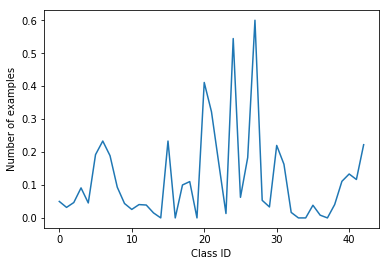

In [86]:
# Visualize distribution of mislabelled classes in the test set

visualize_class_distribution(test_mislabelled_ratio_by_class_dict)

In [87]:
# Pick Top mislabelled classes in validation set

top_mislabelled_test_data_list = get_classes_with_worst_performance(test_mislabelled_ratio_by_class_dict,const_get_top_x_misclassified_classes)
debugLog("List of top mislabelled test data classes : " + str(top_mislabelled_test_data_list))

for (class_id,mislabelled_count) in top_mislabelled_test_data_list:
    debugLog("Class: " + getSignNameForClassId(class_id) + " ||| Mislabelled ratio : " + str(mislabelled_count))


List of top mislabelled test data classes : [(27, 0.59999999999999998), (24, 0.5444444444444444), (20, 0.41111111111111109)]

Class: Pedestrians ||| Mislabelled count : 0.6

Class: Road narrows on the right ||| Mislabelled count : 0.544444444444

Class: Dangerous curve to the right ||| Mislabelled count : 0.411111111111


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images


NewImages/10.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/10.gif Resized and converted to three channels - image shape : (32, 32, 3)

NewImages/13.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/13.gif Resized and converted to three channels - image shape : (32, 32, 3)

NewImages/22.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/22.gif Resized and converted to three channels - image shape : (32, 32, 3)

NewImages/25.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/25.gif Resized and converted to three channels - image shape : (32, 32, 3)

NewImages/26.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/26.gif Resized and converted to three channels - image shape : (32, 32, 3)

NewImages/27.gif - Original image shape : (80, 120, 4)
Resized image shape - (32, 32, 3)

NewImages/27.gif Resized and 

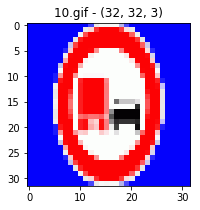

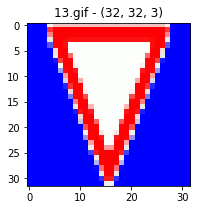

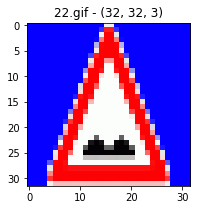

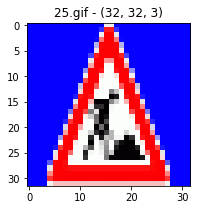

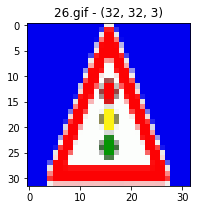

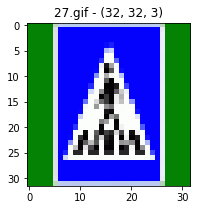

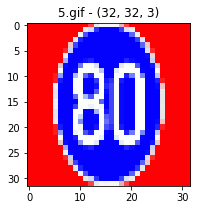

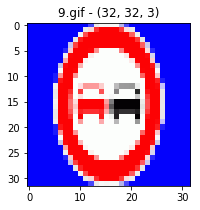

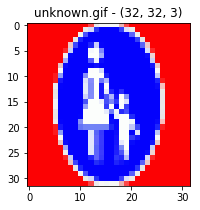

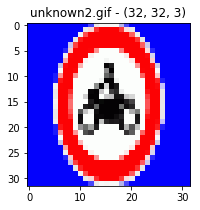

In [58]:
## Load the images from the folder 'const_new_images_folder'
## Reduce dimensions to 32x32 so that they are compatible with our network
## Reduce depth from 4 channels to 3 channels by discarding the alpha channel so that this is compatible with our network
## Visualize the resized image

def load_normalize_and_visualize_new_images():
    new_images_list = list()
    for filename in os.listdir(const_new_images_folder):
        if filename.endswith(".gif"): 
            image_file_relative_path = os.path.join(const_new_images_folder, filename)
            image = mpimg.imread(image_file_relative_path)
            image_shape_string = str(image.shape)
            debugLog(image_file_relative_path + " - Original image shape : " + image_shape_string)
            resized_image = cv2.resize(image, (32, 32))
            resized_image_three_channel = resized_image
            if len(resized_image.shape) > 2 and resized_image.shape[2] == 4: # Check if image has >1 and <4 channels
                resized_image_three_channel = cv2.cvtColor(resized_image, cv2.COLOR_BGRA2BGR)
            new_images_list.append(resized_image_three_channel)
            print("Resized image shape - " + str(resized_image_three_channel.shape))
            resized_image_three_channel_shape_string = str(resized_image_three_channel.shape)
            debugLog(image_file_relative_path + " Resized and converted to three channels - image shape : " + resized_image_three_channel_shape_string)
            plt.figure(figsize=(3,3))
            plt.title(filename + " - " + resized_image_three_channel_shape_string)
            plt.imshow(resized_image_three_channel)   
    return new_images_list

new_images = np.array(load_normalize_and_visualize_new_images(), dtype=np.float32) # Numpy array conversion to have properly formatted list data
debugLog(new_images.shape)


### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [59]:
debugLog("Starting predictions against new images.")

### Testing the trained model against test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = tf.argmax(logits,1)
    best_predictions = sess.run(prediction, feed_dict={x: new_images, keep_prob:1})
    debugLog("Best Class predictions for new images are : " + str(best_predictions))
    for best_prediction in best_predictions:
        predicted_sign_name = getSignNameForClassId(best_prediction)
        debugLog("predicted_sign_name : " + predicted_sign_name)
        
debugLog("Completed predictions against new images.")


Starting predictions against new images.

Best Class predictions for new images are : [10 13 22 25 26 34 38  9 38  4]

predicted_sign_name : No passing for vehicles over 3.5 metric tons

predicted_sign_name : Yield

predicted_sign_name : Bumpy road

predicted_sign_name : Road work

predicted_sign_name : Traffic signals

predicted_sign_name : Turn left ahead

predicted_sign_name : Keep right

predicted_sign_name : No passing

predicted_sign_name : Keep right

predicted_sign_name : Speed limit (70km/h)

Completed predictions against new images.


### Analyze Performance

### 60% ( 6 out of 10 new images predicted correctly )

### Incorrectly classified images


NewImages/27.gif - Original image shape : (80, 120, 4)

NewImages/5.gif - Original image shape : (80, 120, 4)

NewImages/unknown.gif - Original image shape : (80, 120, 4)

NewImages/unknown2.gif - Original image shape : (80, 120, 4)


array([[[  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        ..., 
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0]],

       [[  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        ..., 
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0]],

       [[  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        ..., 
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0]],

       ..., 
       [[  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        ..., 
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0]],

       [[  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        ..., 
        [  4,   2, 252,   0],
        [  4,   2, 252,   0],
        [  4,   2, 252,   0]],

       

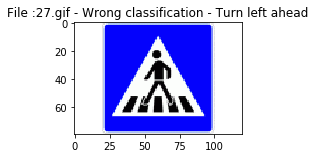

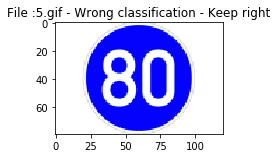

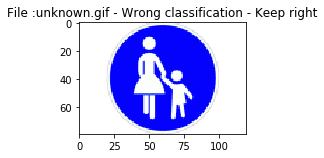

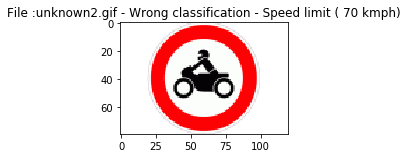

In [60]:
# 27.gif

# 5.gif

# unknown.gif

# unknown2.gif

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def load_visualize_file_with_name(param_filename, title=""):
    return_image = None
    for filename in os.listdir(const_new_images_folder):
        if filename == param_filename: 
            image_file_relative_path = os.path.join(const_new_images_folder, filename)
            image = mpimg.imread(image_file_relative_path)
            return_image = image
            image_shape_string = str(image.shape)
            debugLog(image_file_relative_path + " - Original image shape : " + image_shape_string)
            plt.figure(figsize=(3,3))
            plt.title("File :" + filename + " - " + title )
            plt.imshow(image)   
    return return_image

load_visualize_file_with_name('27.gif','Wrong classification - Turn left ahead')
load_visualize_file_with_name('5.gif','Wrong classification - Keep right')
load_visualize_file_with_name('unknown.gif','Wrong classification - Keep right')
load_visualize_file_with_name('unknown2.gif','Wrong classification - Speed limit ( 70 kmph)')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [61]:
debugLog("Starting top 5 Softmax probabilities for new German traffic images found on the web.")

top_labels_list_for_new_images = None # List of predicted labels for the new images

### Testing the trained model against test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_predictions = tf.nn.top_k(logits,const_top_k_softmax)
    top_prediction_values, top_prediction_indices = sess.run(top_predictions, feed_dict={x: new_images, keep_prob:1})
    
    top_labels_list_for_new_images = np.empty(top_prediction_indices.shape,dtype="S40")
    
    for index, classId in np.ndenumerate(top_prediction_indices):
        label = getSignNameForClassId(classId)
        top_labels_list_for_new_images[index] = label

    debugLog("Top five predicted classification IDs for each new image : " + "\n" + str(top_prediction_indices))
    debugLog("Top five predicted softmax probabilities for each new image : " + "\n" + str(top_prediction_values))
    debugLog("Top five predicted classification Names for each new image : " + "\n" + str(top_labels_list_for_new_images))
  
debugLog("Completed top 5 Softmax probabilities for new German traffic images found on the web.")


Starting top 5 Softmax probabilities for new German traffic images found on the web.

Top five predicted classification IDs for each new image : 
[[10 42  9 23 20]
 [13 35 14 12 38]
 [22 29 25 26 20]
 [25  5 20  1 33]
 [26 18 25 14 12]
 [34 37 38 18 26]
 [38 39  4 40 34]
 [ 9 41 16 17 19]
 [38 34 37 26 18]
 [ 4 21 40  1  5]]

Top five predicted softmax probabilities for each new image : 
[[  8335.83300781   2348.12255859   1901.12780762   1861.78588867
    1805.05773926]
 [  8925.43261719    816.16271973    248.01979065   -347.30929565
   -1119.0526123 ]
 [  5780.97265625   5295.85595703   2839.86523438   1358.33337402
     351.11810303]
 [ 18895.16992188    385.11053467    109.29756165  -1021.15533447
   -1568.81652832]
 [ 10750.28613281     40.41530609   -856.95379639  -1990.81176758
   -2081.71484375]
 [  5866.06494141   3637.19189453   2145.17993164   2095.66210938
    1761.33703613]
 [  4890.07373047    647.90124512    410.08132935    222.31037903
   -1279.0090332 ]
 [  5422.9462

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [67]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Additional exploration

* A top level hyper parameter optimizer, which tweak(s) a hyper parameter, evaluates whether the model is improving ( e.g. in 10 epochs ), and then prints results of this evaluation to a human readable format, and then slowly does this for all the hyper parameters. This will automate a lot of the mundane task(s) around hyper parameter optimization.
* I was a bit conservative with the model, in the sense that I took the LeNet model and tweaked it to achieve the necessary performance. An even better approach would be start off with other model(s) like GoogleNet, or to start building a model from scratch and to evaluate it at every stage. 
* You can use the concept of a TensorFlow Summary writer to save training summaries for a session.

* Immediate Next - latest :
* Iterate on the Write-up.
* Export RC version of the notebook – HTML and Notebook.
* Evaluate which validation classes are failing the most, and for those, generate new fake data and re-train the model on the new fake data, and then evaluate the performance on the validation data, and then eventually against the testing data.
* Any additional tuning items like – L2, deeper CNN, other optimizers, other pooling strategies, preprocessing like greyscaling. 

* Explore visualization samples - The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.
* Do visualization of activation.
* Do visualization of prediction accuracy for validation data
* Do visualization of softmax probabilities for a particular new image

* Feature co ordinates within the image have been provided, so we could extract and use this information in some form.
* Implement Learning Rate Decay if accuracy does not improve over x-iterations.
* Review ConvNetJS to check out how they implement various Data Visualizations in real time and see if you can incorporate those.
* For example using ConvNetJS, initiate a conv net training process, and see how the visualizations update in real time.
* Start on Keras, Transfer learning, behavioral cloning. 
* Write a blog post on saving a model, and restoring it with Tensorflow.

### Retrospective - What went well

* Defining Convenience functions up-front helped with using them from different contexts. Additionally, these functions are general purpose, and can be used for other projects / subsequent assignments as well.
* Defining convenience functions and testing them right away also helped in reducing surprises.
* Identifying hyper parameters, up front gave me a good visibility into the knobs which I had for tuning.
* Became fairly comfortable with designing convolution layer(s) with different filter sizes, strides and depths.
* Logging at different level(s) helped me in getting the right level of information, and the right time. During development of a new feature, I debugLogged anything that needed to be logged, and once dev / testing on that feature was complete, I changed it to infoLog.
* For generated model(s), save them only if their validation accuracy improves.
* For generated model(s), save their validation accuracy in the file name, so that you have quick visibility into that information.


### Retrospective - Areas for improvement

* I struggled a bit, with restoring saved Tensorflow model(s). Because I was able to successfully complete the LeNet Lab on my own, I did not review the solution ( where restoration code was provided ). At one time, I had achieved a validation performance of 96.5% but at the time I did not know how to restore that model, hence I 'lost' that model over subsequent runs. **Learning** : Review the solution, even if you succeed in doing things on your own because you might still get to learn something new.
* The images loaded from the data set had a dtype of unit8, because of which when I tried to normalize and save them, the pixel intensities became integers, and so therefore always either 0 or 1. This naturally led to extremely low prediction accuracies. When I visualized the output images, it helped me detect the anomaly and then fix it. **Learning** : For image manipulation processes, visualize the output immediately after the manipulation to check if it looks as expected.
* Not necessarily an area for improvement, but more of familiarization with the Jupyter notebooks was that often I ran into Memory issues after running the notebook for a few hours. Also, in certain situations, the kernel died randomly. **Learning** : If you are running out of memory issues, it might be because you have chosen a large batch size. To mitigate this, reduce the batch size, terminate all unnecessary applicatins, terminate and restart your browser, and Docker and the Jupyter notebook.
* The process of training over multiple epochs took some time, and it took me some time to become patient and accept it as part of the dev workflow. **Learning** : Training a model is a time consuming process, so patience, coffee and liberal usage of GPUs is recommended ! Also, save good models aggresively, so that you can always restore them later if something goes wrong, and therefore you can 'save' all the effort that has been invested thus far into training the model.
* I am still not as comfortable with TensorFlow model save and restore, as I would like to be. **Learning** : Continue exploring TF model save and restore.

### Tensorflow - best practices and other resources


1. https://github.com/aicodes/tf-bestpractice
2. https://www.tensorflow.org/performance/performance_guide#best_practices
3. https://indico.io/blog/the-good-bad-ugly-of-tensorflow/
4. https://www.hakkalabs.co/articles/fabrizio
5. http://web.stanford.edu/class/cs20si/syllabus.html

### Popular CNN architectures

1. https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html
2. http://slazebni.cs.illinois.edu/spring17/lec04_advanced_cnn.pdf
3. https://www.tensorflow.org/tutorials/image_recognition
4. https://culurciello.github.io/tech/2016/06/04/nets.html